## This will be the codebase for the dictionary learning portion

In [1]:
from sklearn.feature_extraction import image as image_extractor
from skimage import io
import matplotlib.pyplot as plt
from scipy import ndimage
import csv
import numpy as np
import distutils
from distutils import util

### Read the image

In [2]:
image = io.imread("0.210521.png",as_gray=True)

Load as grayscale image (because we know that the image has no color), and also convert to floating point, to operate on real numbers, not on integers.

In [3]:
image.shape

(260, 346)

In [4]:
image.dtype

dtype('float64')

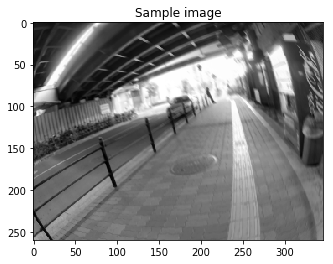

In [5]:
plt.imshow(image, cmap='gray')
plt.title('Sample image')
plt.show()

### Calculate the X and Y derivative using sobel operator. This is very good with edge detection

In [6]:
image_x = ndimage.sobel(image, axis=0)
image_y = ndimage.sobel(image, axis=1)

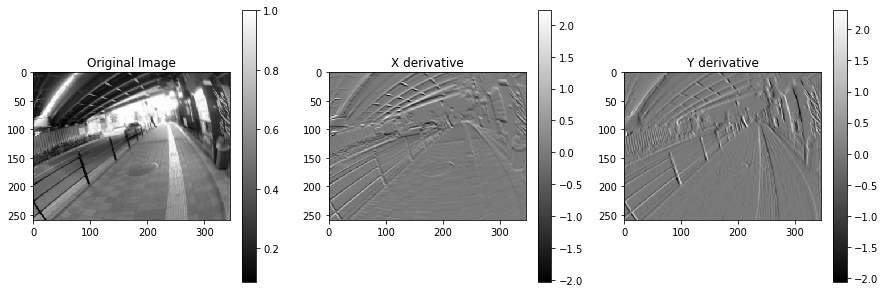

In [7]:
fig, (ax1,ax2, ax3) = plt.subplots(1, 3, figsize = (15, 5), sharex = True)

p1 = ax1.imshow(image, cmap='gray')
ax1.set_title('Original Image')
plt.colorbar(p1,ax=ax1)

p2 = ax2.imshow(image_x, cmap='gray')
ax2.set_title('X derivative')
plt.colorbar(p2,ax=ax2)

p3 = ax3.imshow(image_y, cmap='gray')
ax3.set_title('Y derivative')
plt.colorbar(p3,ax=ax3)

plt.show()

In [8]:
patch_size = (5, 5)
patches_x = image_extractor.extract_patches_2d(image_x, patch_size)
patches_y = image_extractor.extract_patches_2d(image_y, patch_size)

In [9]:
patches_x.shape

(87552, 5, 5)

In [10]:
data = patches_x.reshape(patches_x.shape[0], -1)
data = patches_y.reshape(patches_y.shape[0], -1)
data.shape

(87552, 25)

## Create the event histogram

In [18]:
num_time_slices = 5
img_pos = np.zeros((image.shape[0], image.shape[1], num_time_slices), np.float64)
img_neg = np.zeros((image.shape[0], image.shape[1], num_time_slices), np.float64)

In [19]:
# read the file and store it in different arrays 
timestamp = []
x = []
y = []
pol = []

with open('event_data.csv') as csvfile:
    event_file = csv.reader(csvfile, delimiter=',')
    next(event_file)
    for row in event_file:
        if len(row) == 0:
            continue; # while writing, an additional alternative empty row is written in the excel. so skippping
        x.append(int(row[0]))
        y.append(int(row[1]))
        timestamp.append(float(row[2]))
        pol.append(distutils.util.strtobool(row[3]))
        
assert len(x) == len(y) == len(pol) == len(timestamp)

In [20]:
total_num_events = len(x)

In [21]:
total_num_events

39969

Convert to numpy arrays

In [22]:
x = np.array(x)
y = np.array(y)
timestamp = np.array(timestamp)
pol = np.array(pol)

In [23]:
t_max = np.amax(timestamp)
t_min = np.amin(timestamp)
t_range = t_max - t_min
dt_cell = t_range / num_time_slices
t_edges = np.linspace(t_min,t_max,num_time_slices+1) # boundaries of the cells; not needed

# Specify bin edges in each dimension
bin_edges = (np.linspace(0,image.shape[0],image.shape[0]+1), 
             np.linspace(0,image.shape[1],image.shape[1]+1), t_edges)
yxt = np.transpose(np.array([y, x, timestamp])) # all events
voxelgrid, edges = np.histogramdd(yxt, bins=bin_edges)

In [24]:
voxelgrid.shape

(260, 346, 5)

In [27]:
a = np.array([1, 2, 3, 6, 7])

In [32]:
a>3

array([False, False, False,  True,  True])

In [39]:
# positive events only
idx_pos = pol==0
yxt_pos = np.transpose(np.array([y[idx_pos], x[idx_pos], timestamp[idx_pos]]))
voxelgrid_pos, _ = np.histogramdd(yxt_pos, bins=bin_edges)

# positive events only
idx_neg = pol!=0
yxt_neg = np.transpose(np.array([y[idx_neg], x[idx_neg], timestamp[idx_neg]]))
voxelgrid_neg, _ = np.histogramdd(yxt_neg, bins=bin_edges)

In [40]:
voxelgrid_pos.shape

(260, 346, 5)

It is a bit more complicated: I think it is better that the chuncks have equal time span $\Delta t$, rather than equal number of events. See the code from Ex 2 in the course to create the voxel grids.

In [33]:
# %% Positive and negative events in separate images
# Took this portion from https://gitlab.tubit.tu-berlin.de/guillermo.gallego/events_viz/blob/master/ex2_events_visualization.py
for index, chunk in enumerate(array_event_range):
    for i in chunk:
        if (pol[i]):
            img_pos[index, y[i],x[i]] += 1
        else:
            img_neg[index, y[i],x[i]] += 1

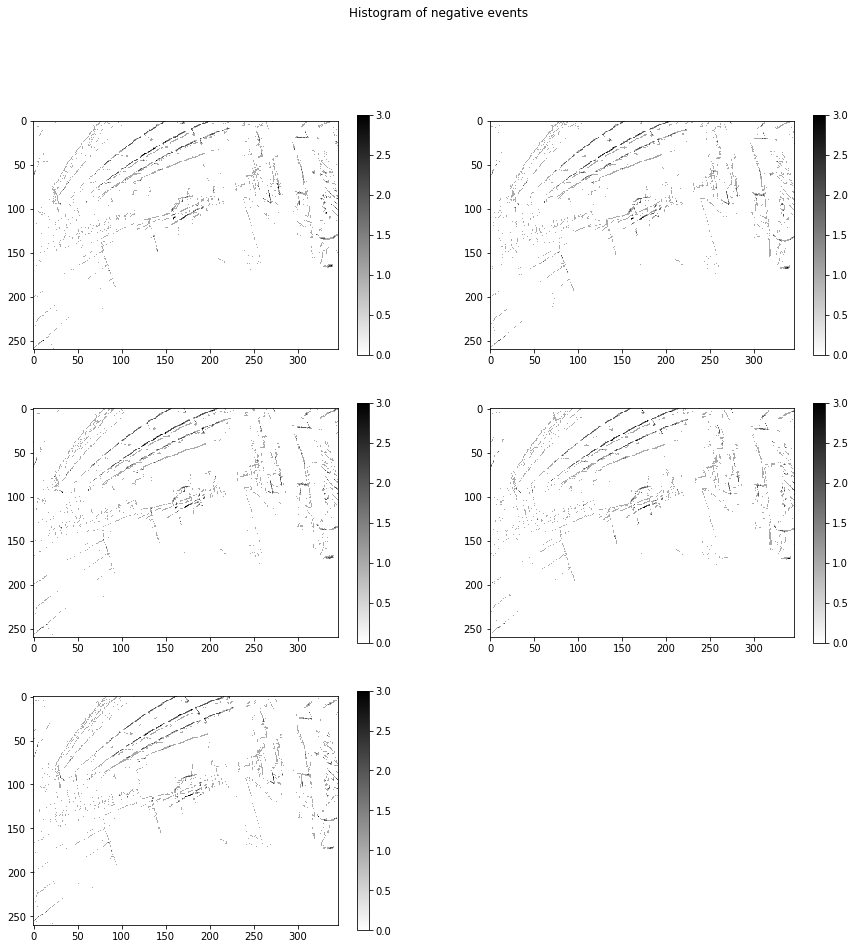

In [42]:
fig, axs = plt.subplots(3, 2, figsize=(15, 15))
fig.suptitle('Histogram of negative events')

for i in range(num_time_slices):
    plt.sca(axs[int(i/2),i%2])
    plt.imshow(voxelgrid_neg[:,:,i], cmap='gray_r')
    plt.colorbar()

axs.flat[-1].set_visible(False)

plt.show()

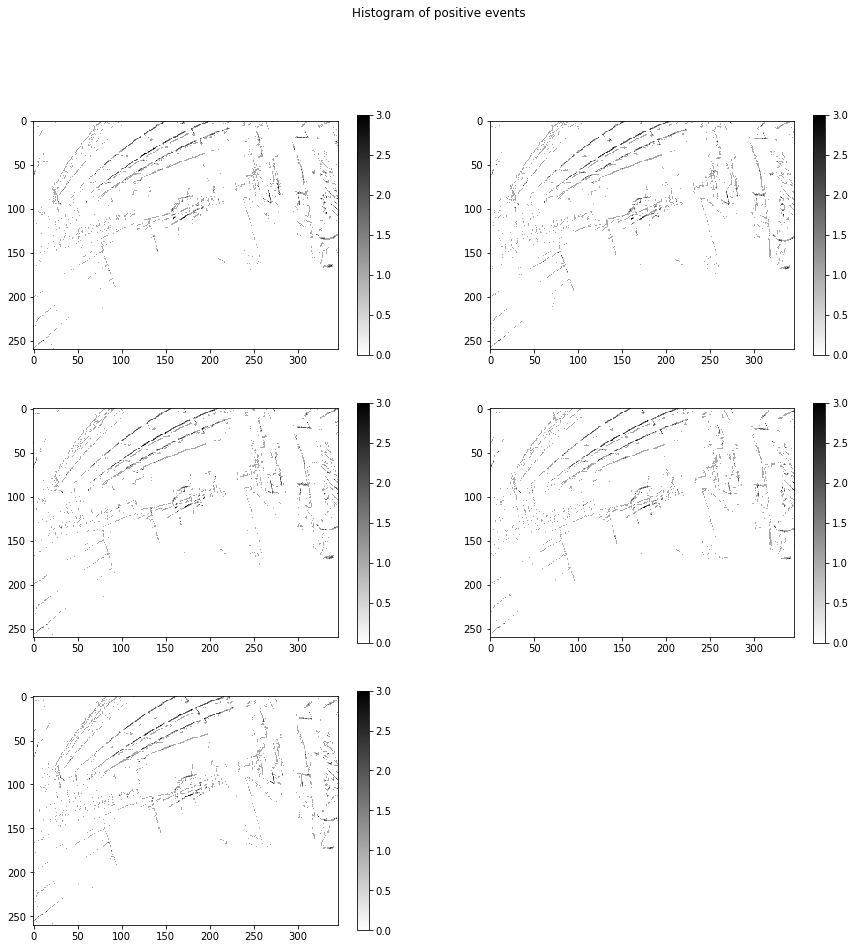

In [14]:
fig, axs = plt.subplots(3, 2, figsize=(15, 15))
fig.suptitle('Histogram of positive events')

for i in range(num_time_slices):
    plt.sca(axs[int(i/2),i%2])
    plt.imshow(voxelgrid_neg[:,:,i], cmap='gray_r')
    plt.colorbar()

plt.sca(axs[0,0])
plt.imshow(img_pos[0 ,: :], cmap='gray_r')
plt.colorbar()

plt.sca(axs[0,1])
plt.imshow(img_pos[1 ,: :], cmap='gray_r')
plt.colorbar()

plt.sca(axs[1,0])
plt.imshow(img_pos[2 ,: :], cmap='gray_r')
plt.colorbar()

plt.sca(axs[1,1])
plt.imshow(img_pos[3 ,: :], cmap='gray_r')
plt.colorbar()

plt.sca(axs[2,0])
plt.imshow(img_pos[4 ,: :], cmap='gray_r')
plt.colorbar()

axs.flat[-1].set_visible(False)

plt.show()